In [3]:
%%html
<center>Photo Credit: <a href="https://pixabay.com/illustrations/police-crime-scene-blue-light-2167968/">pixabay</a><BR><img src="img/police-2167968_1280.jpg" align="center"></center>

<h1><strong><center>CMSC320 Final Project<BR>Predicting the Crime 'Theft From Auto' in Washington, DC<center></strong></h1>
    <center><i>Group members: Leo Wu, Kevin Nguyen, Cindy Huynh<BR>Spring 2020 - Hector Corada Bravo</i></center>

# Introduction

Crime culture is different in different areas. 
In the past, Chicago and Los Angeles have been known for gangs (ChicagoMag, 2012).
Currently, Baltimore, Maryland, is considered the deadliest US city with 348 killings by the end of 2019, which is not the final value yet (Kennedy, 2020).
Therefore, due to the proximity of Washington, DC to the University of Maryland, we wanted to examine crime in Washington, DC.
According to the Patch, DC was ranked America's 16th most dangerous city in 2017 (2018).

At DC Atlas, we noticed that Theft From Auto appeared to be significant, in regards to Property Crime (2020). 
According to City of Cincinnati, Ohio, "Theft from Auto" is a crime of opportunity and is preventable (2020).

The question we are interested in is, what are the trends of crime in DC, and would we be able to predict 'Theft from Auto' crime in DC with data for ten years of data 2010-2019?


In [2]:
#Importing required libraries
from ipyleaflet import *
import warnings
import pandas as pd
import sklearn.ensemble
from sklearn import neighbors
from sklearn.model_selection import KFold
import sklearn.metrics
import matplotlib.pylab as plt
import numpy as np
import seaborn as sns
import statsmodels.formula.api as smf
warnings.filterwarnings('ignore')


# Data Curation
<span style="font-family: Arial">
The data was obtained from Open Data DC site at https://opendata.dc.gov/datasets/crime-incidents-in-2010 through https://opendata.dc.gov/datasets/crime-incidents-in-2019. 
Spreadsheets were downloaded from the site and combined into one spreadsheet for ten years of data from 2010 to 2019.
Approximately 33,000 to 38,000 entities/observations were obtained from each year, totalling approximately 350,000 observation in total (349,343 to be exact).<BR><BR>
In data science, when we want to extract desired data from a website, we usually get more than what we needed. We may get useless data or garabage data that we won't need. To get around this, we tidy our data to make a cleaner dataset for us to work with. There are a few ways to tidy our data: Gathering (eliminate the column headers with values and replace with variable name), splitting (separate the multiple variables stored in one column), rotating (when there are variables storied both in rows and column), normalizing (separating multiple types of obersavtional units that are stored in the same table into multiple different tables), and joining (combining multiple datasets based on a condition into one dataset).<BR><BR>
In our tutorial, we tidy our trained data (2010-2019) by dropping any unnecessary columns of data, leaving only the latitude as X, longitude as Y (the coordinates to where the crime was reported), report date (date the police officer recorded the report), start date (the date the crime started), end date (date the crime supposedly ended), and offense (theft from auto).<BR><BR>
We then dropped any entities/observations with missing data in any fields. We converted any date/time fields to datetime objects in python. Examples and usage can be found at <a href="https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.to_datetime.html">https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.to_datetime.html</a> and <a href="https://colab.research.google.com/github/gal-a/blog/blob/master/docs/notebooks/pandas/pandas_datetime.ipynb">https://colab.research.google.com/github/gal-a/blog/blob/master/docs/notebooks/pandas/pandas_datetime.ipynb</a>.
<BR><BR>
    <strong>Purpose: </strong>Our overall goal is to predict what will happen in 2020 in terms of Theft from Auto (TFA) crimes. Therefore, we will train our ML models on the data from 2010-2019 to test or predict the data in 2020.
<BR>
    <strong>Further tidying:</strong> Since we identified that we still have some unrelated data, we could either remove it from our dataset, or filter it out to ignore it. We chose to filter it out later on ie. during out Prediction task to generate a table for totals for each year, and use that as our training data for Machine Learning. Since report dates would report crime that did not necessarily start in the same year it was reported, we can filter out the data many different ways. <i>It is important to document the method that was used so that <strong>reproducibility</strong> can occur.</i> Since we know that very few reported crimes did not start the same year it was reported, we ignore entities/observations that do not match a start date between years 2010-2019, by filtering for year 2010 start date.<BR><BR>
   In df dataset, our entire data is stored here.<BR>
In df1 dataset, we filtered out only THEFT F/AUTO occurences. This is a sizeable amount of data from our dataset.<BR>
In df2 dataset, we sampled 1000 observations from the entire dataset to plot on a map. This includes observations other than THEFT F/AUTO.<BR>
In tmp dataset, we filter out crime start years 2010-2019 to use as our training data for the Prediction Task / Machine Learning (ML) models.


In [3]:
#read the CSV file. df1 is full dataset dataframe
df1 = pd.read_csv("./Crime_Incidents_in_2010_to_2019.csv")
#df is filtered dataset. filter for TFA offenses, drop unnecessary columns, drop rows w any fields containing NA
df = (df1.query('OFFENSE == "THEFT F/AUTO"')
        .drop(columns = ['BID','LONGITUDE','LATITUDE','VOTING_PRECINCT', 'OBJECTID',
                        'OCTO_RECORD_ID','CCN','SHIFT','BLOCK','XBLOCK','YBLOCK','WARD',
                        'ANC','DISTRICT','PSA','METHOD','NEIGHBORHOOD_CLUSTER','BLOCK_GROUP',
                        'CENSUS_TRACT'])
        .dropna())

#converting date/time text to datetime objects for df and df1
df1['START_DATE'] = pd.to_datetime(df1.START_DATE, format="%Y-%m", errors='coerce')
df1['END_DATE'] = pd.to_datetime(df1.END_DATE, format="%Y-%m", errors='coerce')
df1['REPORT_DAT'] = pd.to_datetime(df1.REPORT_DAT, format="%Y-%m", errors='coerce')
df1.dropna()
df['START_DATE'] = pd.to_datetime(df.START_DATE, format="%Y-%m")
df['END_DATE'] = pd.to_datetime(df.END_DATE, format="%Y-%m")
df['REPORT_DAT'] = pd.to_datetime(df.REPORT_DAT, format="%Y-%m")
df #entire dataset for prediction task

#sample size of 1000 for mapping, labels will use 'strings' for datetimes
df2 = df.sample(n=1000) 

#display the filtered dataframe, note all offenses are THEFT F/AUTO
df.head()

,X,Y,REPORT_DAT,START_DATE,END_DATE,OFFENSE
5,-77.070211,38.913641,1915-10-17 21:00:57+00:00,2015-10-18 06:00:03+00:00,2015-10-24 16:53:07+00:00,THEFT F/AUTO
15,-77.020728,38.931145,2010-01-01 00:01:00+00:00,2009-12-31 22:30:00+00:00,2010-01-01 00:00:00+00:00,THEFT F/AUTO
17,-77.079550,38.943975,2010-01-01 01:15:00+00:00,2010-01-01 15:00:00+00:00,2010-01-01 23:55:00+00:00,THEFT F/AUTO
30,-77.036461,38.934970,2010-01-01 06:25:00+00:00,2009-12-31 23:00:00+00:00,2010-01-01 05:30:00+00:00,THEFT F/AUTO
34,-77.081195,38.930290,2010-01-01 07:45:00+00:00,2009-12-31 21:00:00+00:00,2010-01-01 07:00:00+00:00,THEFT F/AUTO


<strong>Map Title:</strong> Theft From Auto Crime from 2010-2019 in DC<BR>
<strong>Description:</strong> The data can be plotted on to a map, especially if it has geographical coordinates, longitude and latitude. This map shows each theft from automobile crime that was taken in the sample from the dataframe. This is the geographical map with data points for a sample size of 1000 from data containing observations for theft from auto crimes from 2010-2019. The the sample dataset was used to plot the points in the map below using the python map module. See <a href="https://docs.python.org/3/library/functions.html#map">https://docs.python.org/3/library/functions.html#map</a> for more information. 

In [6]:
m = Map(center = (38.8951, -77.0364), zoom = 11)
for i in df2.iterrows():
    data = i[1]
    circle = Circle()
    circle.location = (data[1], data[0])
    circle.radius = 1
    circle.color = "green"
    circle.fill_color = "green"
    
    m.add_layer(circle)
m

Map(center=[38.8951, -77.0364], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'z…

We can make an observation that the likelyhood of auto theft crime will occur would be near the center of DC. The data points shown are denser towards the center of Washington which implies that the frequency of auto theft occuring is higher there.

## Prediction task - Machine Learning

In Machine Learning (ML) we use classifiers to help train our data to make predictions. A classifier is a hypothesis used to categorize and assign labels to particular data points. An example of a classifier would be: determining if someone would go out to play tennis on a sunny day based on a dataset that shows if that person went out to play tennis that day and the type of weather that occurs during the same day played. <BR><BR>For our tutorial, our classifier would be determining if more people would commit auto theft crime in DC in the future based on a dataset for the previous ten years that tells us the number of auto theft crimes reported, when they are reported, and where the crime that was reported happened.

> Can we predict the number of theft from automobiles in 2020?

Using our train dataset, we will first create a new dataframe that will consist of the years (2010-2019) and the number of theft autos that occur during those years.

In [5]:
#We create another dataframe that shows how much TFA occurred each year
tmp = pd.DataFrame(columns = ['# of Theft From Auto', 'Total Crime'], 
                   index = ['2010', '2011','2012','2013','2014',
                            '2015','2016','2017','2018','2019'])
# any NA values will be marked as 0 instead
tmp = tmp.fillna(0)

#iterate through all rows to see if the year matches
for i in df.iterrows():
    datetime = i[1][3].to_pydatetime() #uses matching start date year
    for j in tmp.iterrows():
        if str(datetime.year) == j[0]:
            tmp['# of Theft From Auto'][j[0]] += 1
for i in df1.iterrows():
    datetime = i[1][3].to_pydatetime() #uses matching start date year
    for j in tmp.iterrows():
        if str(datetime.year) == j[0]:
            tmp['Total Crime'][j[0]] += 1
tmp['TFA %'] = np.where(tmp['Total Crime'] < 1, 0, 100*tmp['# of Theft From Auto']/tmp['Total Crime'])

tmp

,# of Theft From Auto,Total Crime,TFA %
2010,8144,31653,25.728999
2011,9402,33199,28.320130
2012,9722,35126,27.677504
2013,10151,35839,28.323893
2014,11269,38177,29.517772
2015,11251,37066,30.353963
2016,12121,37151,32.626309
2017,10208,33014,30.920216
2018,11624,33811,34.379344
2019,10670,33693,31.668299


<strong>Title:</strong> Table for Statistics for Theft From Auto and Total DC Crime (2010-2019)<BR>
    <strong>Description:</strong> The chart table above is useful for seeing exact values and statistics at a glance about our data. Each attribute provides a useful piece of information about each year.
<BR>There are other ways to do this, such as built-in functions such as summary() table data. <BR><BR>
The tmp dataset is what we will use to train our ML model on. 
    <BR>ML models can include a variety of models, such as linear regression, logistic regression, K Nearest Neighbor (KNN), Decision Tree, and Random Forests.


In [3]:
plot = sns.barplot(x = tmp.index, y = tmp['TFA %'], color = 'blue')
plot.set_position([plot.get_position().x0, 
                   plot.get_position().y0, 
                   plot.get_position().width*2, 
                   plot.get_position().height*2])
plot

NameError: name 'sns' is not defined

# Visualization

<strong>Title:</strong> Barplot of Percentage of Theft From Auto (2010-2019)<BR>
<strong>X-Axis:</strong> Year<BR>
<strong>Y-Axis:</strong> TFA Percentage<BR>
<strong>Description:</strong> (Above) A bar plot can be used to visualize and present the data. Using the undistorted quantities of position and length allow for effective visualization of data.

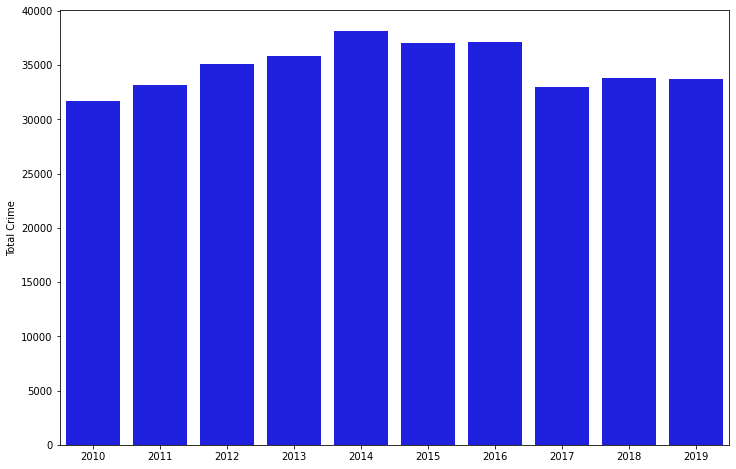

In [7]:
plot = sns.barplot(x = tmp.index, y = tmp['Total Crime'], color = 'blue')
plot.set_position([plot.get_position().x0, 
                   plot.get_position().y0, 
                   plot.get_position().width*2, 
                   plot.get_position().height*2])
plot

<strong>Title:</strong> Barplot of Total Crime Per Year (2010-2019)<BR>
<strong>X-Axis:</strong> Year<BR>
<strong>Y-Axis:</strong> Total Crime<BR>
<strong>Description:</strong> (Above) This bar plot alternatively can be used to show other aspects of the data in a easy to interpret form. One idea that can be used is whether or not crime should be exhibited in a standardized format. For example, using the percent of TFA per year may be a way to standardize the data, since not every year will have the same amount of crime. This bar graph clearly shows there is a peak in crime in 2014.<BR><BR>The barplot above indicates the frequency of theft from cars from the years 2010-2019.<BR>
Based on our observations, the barplot shows some kind of positive relationship between time and the number of thefts from auto. As the years go by, the number of auto theft tends to increase.

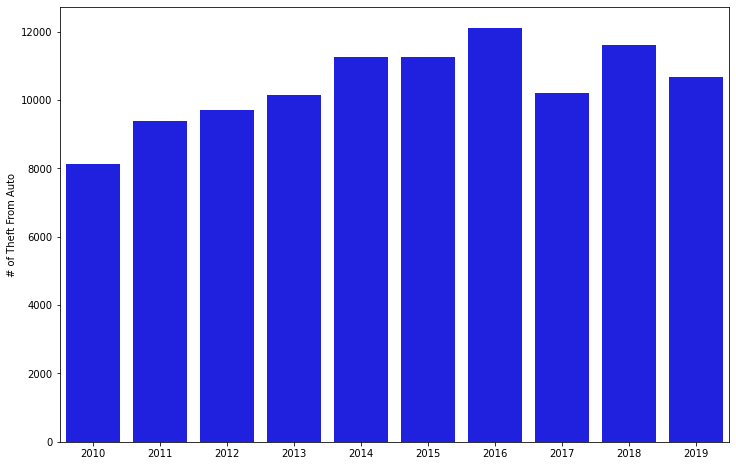

In [8]:
plot = sns.barplot(x = tmp.index, y = tmp['# of Theft From Auto'], color = 'blue')
plot.set_position([plot.get_position().x0, 
                   plot.get_position().y0, 
                   plot.get_position().width*2, 
                   plot.get_position().height*2])
plot

<strong>Title:</strong> Barplot of Amount of TFA per year (2010-2019)<BR>
<strong>X-Axis:</strong> Year<BR>
<strong>Y-Axis:</strong> Amount of TFA<BR>
<strong>Description:</strong> (Above) This bar plot instead shows the number of TFA per year, instead of the percentage of TFA. Interpretations can easily be drawn from visuals such as bar graphs, scatterplots, histograms, violin plots, boxplots, and more. From this bar graph, we can see that the number of theft from auto is not always increasing each year. This may make it more difficult to predict. Also, keep in mind that police departments, are also aware of increasing trends, and may be proactive in running awareness campaigns to curb TFA. This could account for some of the decreases in TFA as seen in 2017 and 2019.

# Machine Learning Models

# Linear Regression
A linear regression line model can be applied to the data for total crime. It appears that total crime has an overall increasing trend over the 2010-2019 time period.

In [5]:
tmp1 = tmp.copy()
tmp1['YEAR'] = [2010,2011,2012,2013,2014,2015,2016,2017,2018,2019]
plot = sns.lmplot(x = 'YEAR', y = 'Total Crime', data = tmp1, ci=True)

plot

NameError: name 'tmp' is not defined

(Below) Now we are going to add a new column "YEAR" to our dataset to organize and group each auto theft case into their own year based on their report date (REPORT_DAT).

In [7]:
df['YEAR'] = df['REPORT_DAT'].apply(lambda x: x.to_pydatetime().year)

### k-fold Cross-Validation

In this section, we will perform a 10-fold cross-validation. K-fold cross-validation is used to check how accurate our machine learning model will be on predictions. It partitions our dataset into k folds or groups, which in this tutorial we will making 10 folds. Out of the k folds, one of them will be assigned as the test data, while the rest of the groups (k-1) are assigned as training data. For the k-1 groups, we model our training data to our test data to measure performance on the prediction. The process is then repeated for every group in k-1 folds.


In [46]:
X = df1.iloc[:,1:2].to_numpy()
y = df1.iloc[:,6:7].to_numpy()
kf = KFold(n_splits=10, shuffle=True)
kf.get_n_splits(X)
print(kf)  

KFold(n_splits=10, random_state=None, shuffle=True)


In [49]:
k = 1
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    clf = neighbors.KNeighborsClassifier(k, weights='uniform')
    clf.fit(X_train, y_train)
    k = k + 1
    Z = clf.predict(X_test)
    y_test = np.ravel(y_test)
    print(str(k-1) + " neighbors: " + str(sklearn.metrics.zero_one_loss(y_test,Z)))

1 neighbors: 0.614999284385287
2 neighbors: 0.6010304851867754
3 neighbors: 0.5959237419133223
4 neighbors: 0.5930612011221159
5 neighbors: 0.584387702524761
6 neighbors: 0.5889963931986031
7 neighbors: 0.5777466078891624
8 neighbors: 0.5743974351634511
9 neighbors: 0.5848743344592661
10 neighbors: 0.5789488750214691


### Random Forest Model

We will be using a random forest model to present our data. Random forest models are excellent at predicting performance and reducing instability by averaging multiple decision trees (also known as Classification tree). This means using a random forest model will provide us a more accurate prediction table. As we know decision trees produce an outcome that is categorical. It predicts where training data will fall into by spliting partitions based on a single attribute. With a random forest model, we can make an average and predict which data point would fall into which category.

### Linear regression model

For our exploratory data analysis, we will use a linear regression model for our hypothesis testing. The linear regression model is a very common technique used to make predictions based on a conditional relationship between two variables. When dealing with visual graphs relating to economics, you usually see this “line of best fit” that tells us the relationship between X and Y-variables. In data science, we call this “line of regression” or the “linear fit” as we regress X-variable on Y-variable. We will use a linear regression model to determine and predict the relationship between years from the crime dataset and the number of auto theft cases reported in those years. 

In [ ]:
## Conclusion

According to our k-fold Cross Validation results, there is high error and therefore we cannot predict the data as our p value is much greater than our propto of 0.05. 
In experiments, it is important not to go back and manipulate the data once we know the results of the experiment, which could be considered p-hacking, which is when a researcher attempts to obtain a p-value result that is significant before submitting their results/research.

high error, cannot predict

<strong>References:</strong><BR>
How to Prevent Theft From Autos. (2020, May 17). City of Cincinnati. https://www.cincinnati-oh.gov/police/community-involvement/how-to-prevent-theft-from-autos/ 
<BR>Moser, W. (2012, Jan 27). Why Are There So Many Gang Members in Chicago? Chicago Magazine. https://www.chicagomag.com/Chicago-Magazine/The-312/January-2012/Why-Are-There-So-Many-Gang-Members-in-Chicago/
<BR>Kennedy, S. (2020, Feb 7). 'The Wire' Is Finished, but Baltimore Still Bleeds. Wall Street Journal. https://www.wsj.com/articles/the-wire-is-finished-but-baltimore-still-bleeds-11581119104
<BR>DC Atlas. (2020). Crime Cards. Metropolitan Police Department. https://dcatlas.dcgis.dc.gov/crimecards/ 
<BR>Taylor, D. (2018, Feb 20). The Patch. https://patch.com/district-columbia/washingtondc/dc-americas-16th-most-dangerous-city 
<BR>    
<BR><strong>Interesting Links:</strong>
<BR>Grawert A., and Kimble, C. (2019, Dec 18). Takeaways from 2019 Crime Data in Major American Cities https://www.brennancenter.org/our-work/analysis-opinion/takeaways-2019-crime-data-major-american-cities
<BR>Madhani, A. (2018, Feb 19). USA Today. Baltimore is the nation's most dangerous big city. https://www.usatoday.com/story/news/2018/02/19/homicides-toll-big-u-s-cities-2017/302763002/
<BR>Best Places. (2020). 2020 Compare Crime Rates: Washington, DC vs Baltimore, MD. https://www.bestplaces.net/crime/?city1=51150000&city2=52404000 
<BR>The Disaster Center. (2007). US States Crime 2004 -2005 Crimes per 100,000 and Ranking. http://www.disastercenter.com/crime/US_States_Rate_Ranking.html  
    